In [1]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [40]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset",
    shuffle=True,
    batch_size=32,
    image_size=(128, 128),
)

Found 10000 files belonging to 100 classes.


In [41]:
labels = dataset.class_names
labels

['Abelmoschus Esculentus (Okra)',
 'Acorus Calamus (Dlingo)',
 'Aloe Vera (Lidah Buaya)',
 'Alstonia Scholaris (Pulai)',
 'Amaranthus Spinosus (Bayam Duri)',
 'Andrographis Paniculata (Sambiloto)',
 'Annona Muricata (Sirsak)',
 'Annona Squamosa (Srikaya)',
 'Anredera Cordifolia (Binahong)',
 'Apium Graveolens (Seledri)',
 'Artocarpus Heterophyllus (Nangka Mini)',
 'Artocarpus Integer (Nangka Cempedak)',
 'Averrhoa Bilimbi (Belimbing Wuluh)',
 'Blumea Balsamifera (Sembung)',
 'Borreria Hispida (Gempur Batu)',
 'Caesalpinia Sappan L (Secang)',
 'Caladium Cicolor (Keladi)',
 'Calendula Officinalis (Marigold)',
 'Canangium Odoratum (Kenanga)',
 'Catharanthus Roseus (Tapak Dara)',
 'Celosia Cristata (Jengger Ayam)',
 'Centella Asiatica (Pegagan)',
 'Cestrum Nocturnum (Sedap Malam)',
 'Citrus Amblycarpa (Jeruk Limau)',
 'Clinalanthus Nutans (Dandang Gendis)',
 'Clitoria Ternatea (Kembang Telang)',
 'Crinum Asiaticum (Bakung Putih)',
 'Curcuma Domestica (Kunyit)',
 'Cyclea Barbata (Cincau Hij

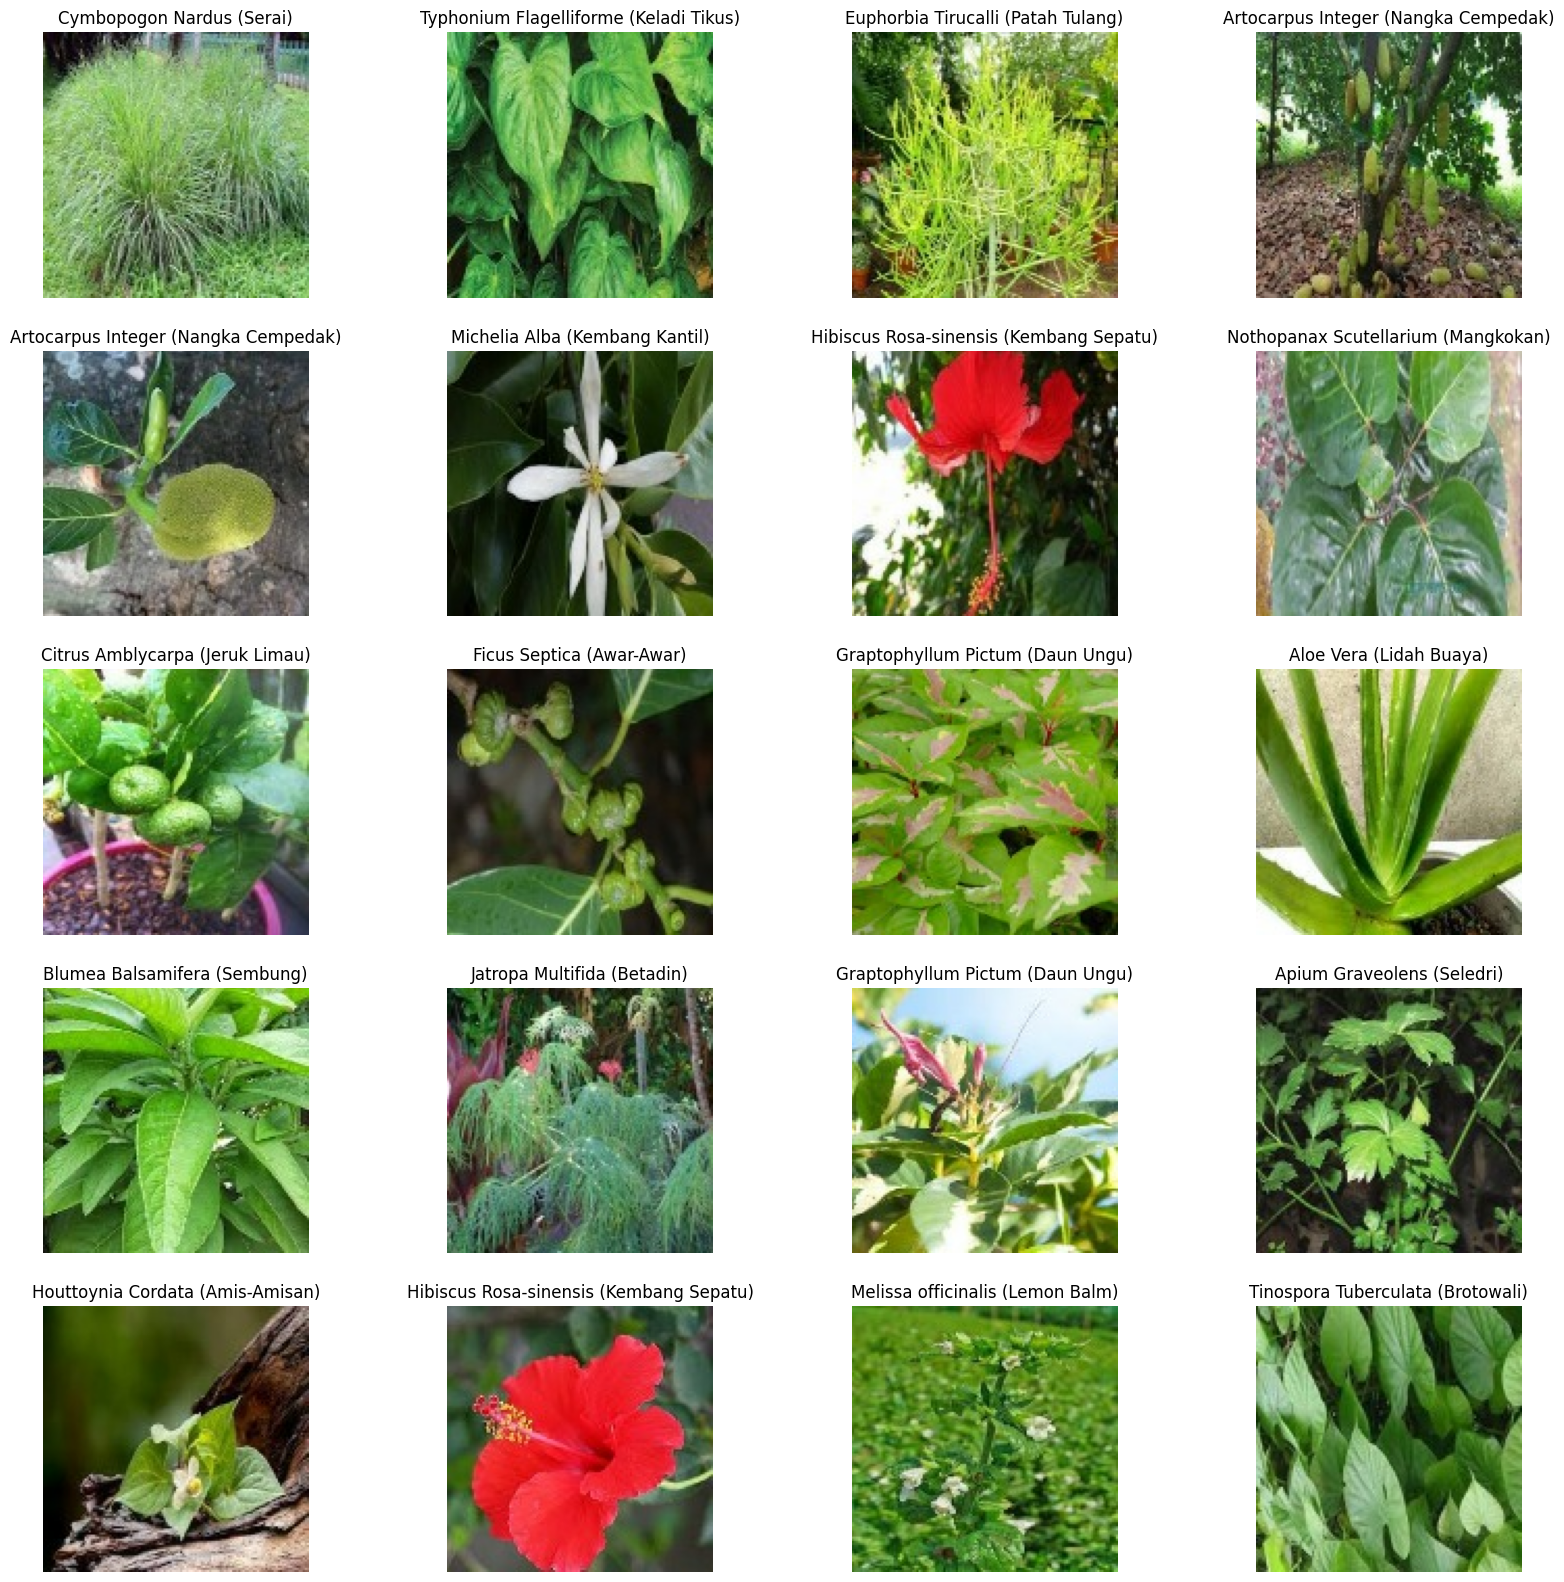

In [5]:
import matplotlib.pyplot as plt

class_names = dataset.class_names

plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)  # 5 rows, 4 columns
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [42]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 128, 128, 3)
[52 28  0 98 41 60 63 42 28  9 43 92 72 91 58 24 68 20 79 25 78 53 15 34
 91 33  1 29 86 38 94 36]


In [60]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
#     assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [61]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(219, 63, 31)

In [9]:
rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [65]:
from tensorflow.keras import regularizers


# train using InceptionV3
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(128, 128, 3),
    include_top=False,
    pooling='avg',
    classifier_activation='softmax',
    classes=len(labels)
)

base_model.trainable = False


inputs = tf.keras.Input(shape=(128, 128, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)  
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x) 
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping]
)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_41 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_24 (Dropout)        (None, 1024)              0         
                                                                 
 dense_42 (Dense)            (None, 100)               102

In [66]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 [==============================] - 6s 26ms/step - loss: 0.1694 - accuracy: 0.9866
Test Loss: 0.1694
Test Accuracy: 0.9866


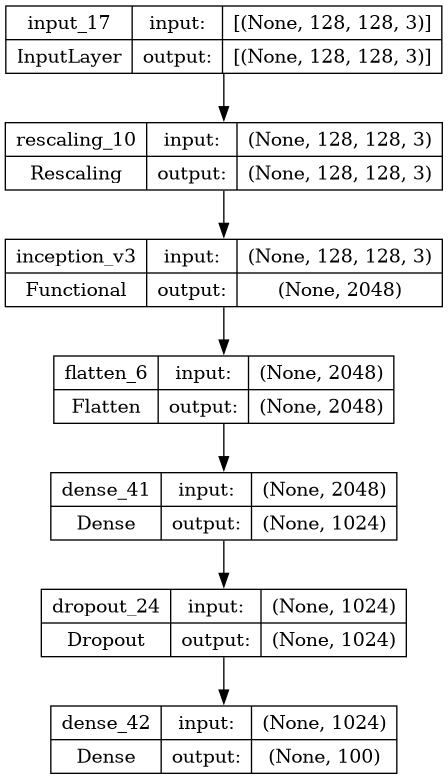

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(model=model, show_shapes=True)

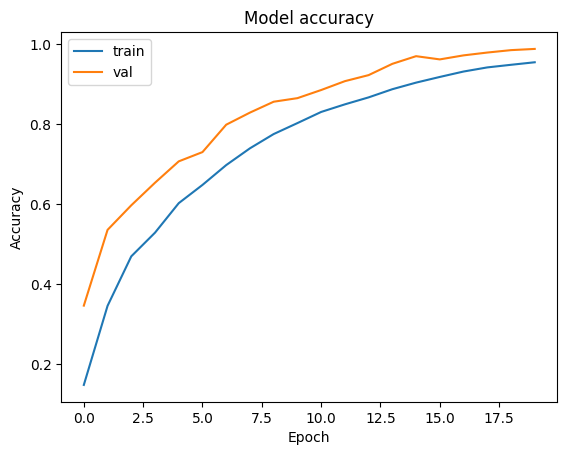

In [68]:
# plot accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

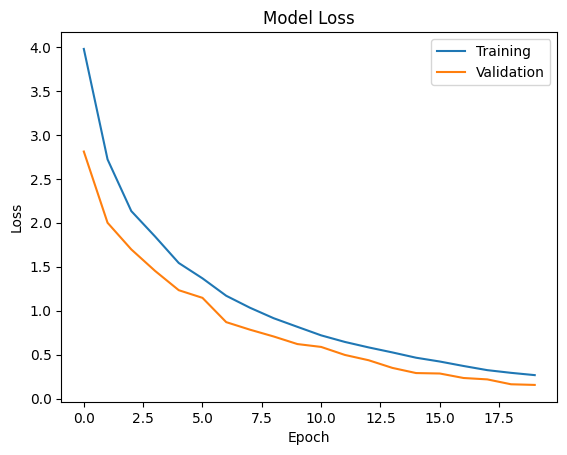

In [69]:
#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [70]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input

1/1 [==============================] - 1s 1s/step


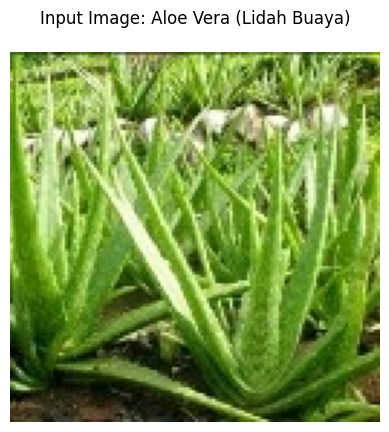

The image most likely belongs to Aloe Vera (Lidah Buaya) with a 67.89% confidence.


In [71]:
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Aloe Vera (Lidah Buaya)/77.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")

1/1 [==============================] - 0s 27ms/step


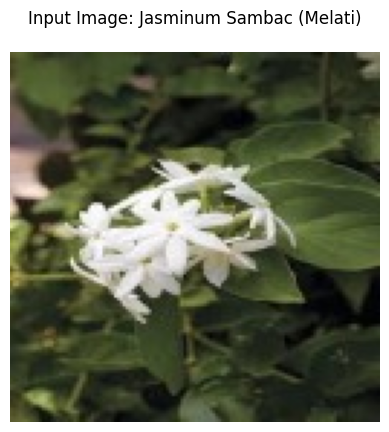

The image most likely belongs to Jasminum Sambac (Melati) with a 69.09% confidence.


In [72]:
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Jasminum Sambac (Melati)/33.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")

1/1 [==============================] - 0s 26ms/step


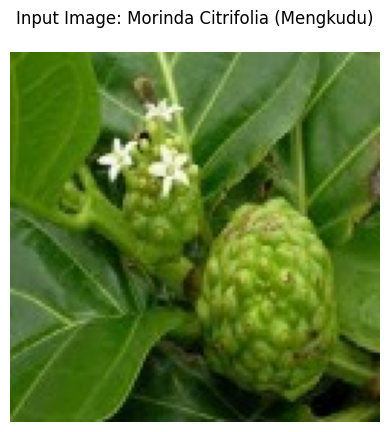

The image most likely belongs to Morinda Citrifolia (Mengkudu) with a 71.69% confidence.


In [73]:
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Morinda Citrifolia (Mengkudu)/62.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")

1/1 [==============================] - 0s 26ms/step


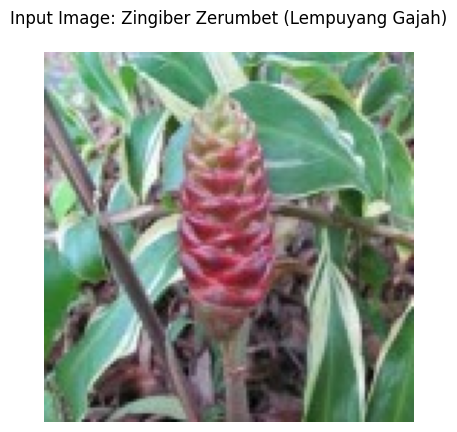

The image most likely belongs to Zingiber Zerumbet (Lempuyang Gajah) with a 73.10% confidence.


In [74]:
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Zingiber Zerumbet (Lempuyang Gajah)/75.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")

1/1 [==============================] - 0s 26ms/step


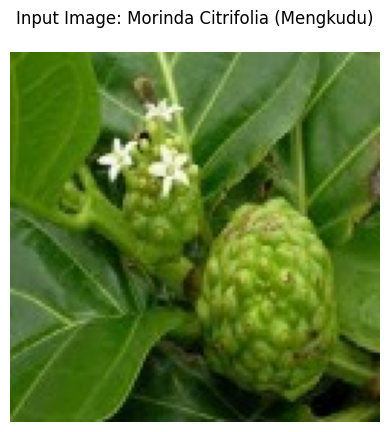

The image most likely belongs to Morinda Citrifolia (Mengkudu) with a 71.69% confidence.


In [75]:
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Morinda Citrifolia (Mengkudu)/62.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")

1/1 [==============================] - 0s 26ms/step


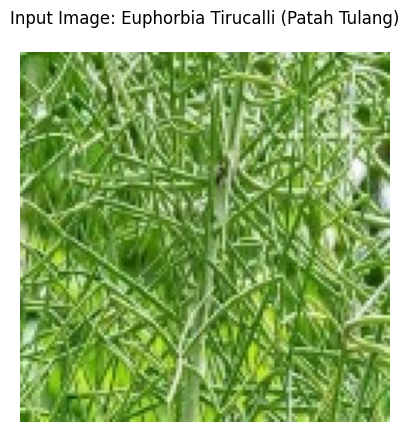

The image most likely belongs to Euphorbia Tirucalli (Patah Tulang) with a 60.10% confidence.


In [77]:
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Euphorbia Tirucalli (Patah Tulang)/2.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")

1/1 [==============================] - 0s 26ms/step


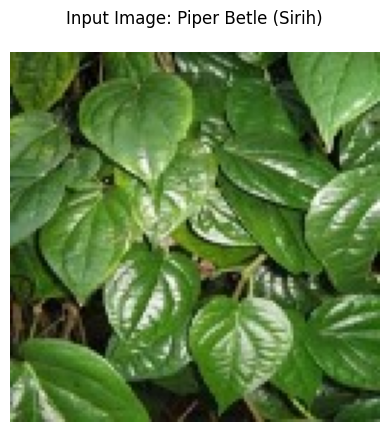

The image most likely belongs to Piper Betle (Sirih) with a 58.23% confidence.


In [78]:
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Piper Betle (Sirih)/20.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")

In [79]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_true = []
y_pred = []

for images, labels_batch in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=labels)
acc_score = accuracy_score(y_true, y_pred)
rec_score = recall_score(y_true, y_pred, average='macro')
prec_score = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

63/63 [==============================] - 6s 26ms/step - loss: 0.1472 - accuracy: 0.9886
Test Loss: 0.1472
Test Accuracy: 0.9886
1/1 [==============================] - 0s 26ms/step


In [80]:
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[22  0  0 ...  0  0  0]
 [ 0 17  0 ...  0  0  0]
 [ 0  0 22 ...  0  0  0]
 ...
 [ 0  0  0 ... 19  0  0]
 [ 0  0  0 ...  0 19  0]
 [ 0  0  0 ...  0  0 18]]


In [81]:
print("\nClassification Report:")
print(class_report)


Classification Report:
                                              precision    recall  f1-score   support

               Abelmoschus Esculentus (Okra)       1.00      1.00      1.00        22
                     Acorus Calamus (Dlingo)       1.00      0.94      0.97        18
                     Aloe Vera (Lidah Buaya)       1.00      1.00      1.00        22
                  Alstonia Scholaris (Pulai)       1.00      1.00      1.00        20
            Amaranthus Spinosus (Bayam Duri)       0.95      0.95      0.95        19
         Andrographis Paniculata (Sambiloto)       0.96      1.00      0.98        24
                    Annona Muricata (Sirsak)       1.00      1.00      1.00        20
                   Annona Squamosa (Srikaya)       1.00      1.00      1.00        17
              Anredera Cordifolia (Binahong)       1.00      1.00      1.00        20
                  Apium Graveolens (Seledri)       1.00      1.00      1.00        23
      Artocarpus Heterophyllu

In [82]:
print("\nAccuracy Score:", acc_score)
print("Recall Score:", rec_score)
print("Precision Score:", prec_score)
print("F1 Score:", f1)


Accuracy Score: 0.9866071428571429
Recall Score: 0.9861872767904536
Precision Score: 0.9869304943383992
F1 Score: 0.9859844153999283


In [83]:
model.save('/kaggle/working/final_model.keras')